# Object Detection Evaluation

This notebook aims at showing what kind of graph you can draw thank's to libia's evaluator

In [1]:
%load_ext autoreload

%autoreload 2
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import numpy as np
import pandas as pd
from libia.evaluation.detection import DetectionEvaluator as de
from libia.utils.grouper import ContinuousGroup
from libia.dataset import from_coco
from libia.evaluation.detection.util import display_confusion_matrix
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the dataset and the predictions

Note that they are both treated as datasets at first, and only when creating the eval object we have a detection evaluator

As a second Note, you can add several prediction datasets at the same time

In [2]:
coco_eval = from_coco("notebook_data/coco_valid.json").remap_from_preset(
    "coco", "supercategory"
)
coco_darknet = from_coco(
    "notebook_data/yolov4_prediction_coco_eval.json"
).remap_from_preset("coco", "supercategory")
evaluator = de(
    groundtruth=coco_eval, predictions=coco_darknet, predictions2=coco_darknet
)

In [3]:
evaluator

## Compute the matches

This is arguably the slowest part.

Hopefully, we can multiprocess it in the future

You can compute them by taking category into account or not.

- The category agnostic is useful for e.g. computing confusion matrices
- The category specific is useful for e.g. computing precision-recall curves

In [4]:
matches = evaluator.compute_matches("predictions", category_agnostic=True)
display(matches["predictions"])
matches = evaluator.compute_matches("predictions", category_agnostic=False)
display(matches["predictions"])

computing matches between groundtruth and predictions (category agnostic)


  0%|          | 0/4979 [00:00<?, ?it/s]

,prediction_id,iou,groundtruth_id
0,48019,0.954652,34646
1,48033,0.912193,104368
2,48034,0.939746,103487
3,48042,0.895466,230831
4,48020,0.922641,35802
...,...,...,...
60,17979,0.000000,<NA>
61,17980,0.000000,<NA>
62,17981,0.000000,<NA>
63,17982,0.000000,<NA>


computing matches between groundtruth and predictions (category specific)


  0%|          | 0/14503 [00:00<?, ?it/s]

,prediction_id,iou,groundtruth_id
0,48042,0.895466,230831
1,48030,0.840631,233201
0,47998,0.000000,<NA>
1,48009,0.000000,<NA>
2,48008,0.000000,<NA>
...,...,...,...
60,17979,0.000000,<NA>
61,17980,0.000000,<NA>
62,17981,0.000000,<NA>
63,17982,0.000000,<NA>


See how two new tabs have been added to the dataset widget

In [5]:
evaluator

Here, we just plot the IOU distribution. As you can see more than half the detections have a IoU of 0. These predictions typically have a very low confidence as well, which means they will be easily filtered and won't have a great influence on evaluation.

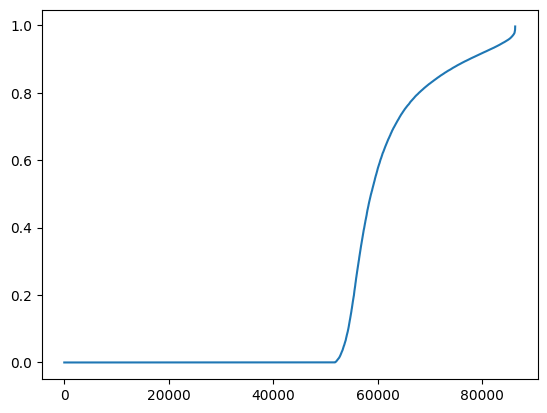

In [6]:
plt.plot(
    evaluator.matches["category_specific"]["predictions"]["iou"].sort_values().values
)

### Computing confusion matrix

The confusion matrix can be computed for all matches or by groups if the argument *groups* is defined.

The values are normalized over the groundtruth.

Notes:
- The class *None* corresponds to the False Positive and False Negative.
- The `model` indicated the name of given predictions. Here, we get the data for confusion for predictions named `predictions` and `predictions2` (which are the same, for the sake of the example)
- Since matches have already been computed for `predictions` we only have to compute them for `predictions2`

In [7]:
confusion_data = evaluator.compute_confusion_matrix()
confusion_data

computing matches between groundtruth and predictions2 (category agnostic)


  0%|          | 0/4979 [00:00<?, ?it/s]

Processing confusion matrix for model=predictions
Processing confusion matrix for model=predictions2


,accessory,animal,appliance,electronic,food,furniture,indoor,kitchen,outdoor,person,sports,vehicle,None,model
label,,,,,,,,,,,,,,
accessory,0.798511,0.002127,0.000532,0.001063,0.002658,0.010101,0.003721,0.003190,0.007443,0.114833,0.005316,0.018075,0.032430,predictions
animal,0.000741,0.938148,0.000370,0.002222,0.000000,0.001852,0.001481,0.000741,0.001481,0.011852,0.001111,0.003333,0.036667,predictions
appliance,0.000000,0.000000,0.862007,0.007168,0.010753,0.026882,0.001792,0.055556,0.000000,0.010753,0.000000,0.001792,0.023297,predictions
electronic,0.005291,0.002268,0.001512,0.876039,0.002268,0.024943,0.012850,0.008314,0.001512,0.020408,0.000000,0.006047,0.038549,predictions
food,0.000000,0.000000,0.004233,0.000000,0.901587,0.029277,0.001411,0.029982,0.000000,0.004586,0.000353,0.001764,0.026808,predictions
furniture,0.008154,0.002912,0.003203,0.007863,0.018637,0.803727,0.015143,0.034362,0.008154,0.055329,0.001165,0.003494,0.037857,predictions
indoor,0.005500,0.002000,0.002500,0.010000,0.002000,0.033500,0.869500,0.014000,0.001500,0.011000,0.000500,0.002500,0.045500,predictions
kitchen,0.002441,0.001627,0.010035,0.002983,0.021969,0.034445,0.009493,0.862219,0.001899,0.009493,0.001356,0.001627,0.040412,predictions
outdoor,0.008554,0.001555,0.000000,0.001555,0.000000,0.020995,0.001555,0.000778,0.797045,0.048212,0.002333,0.017107,0.100311,predictions


### Display confusion matrix for prediction dataframe named "predictions"

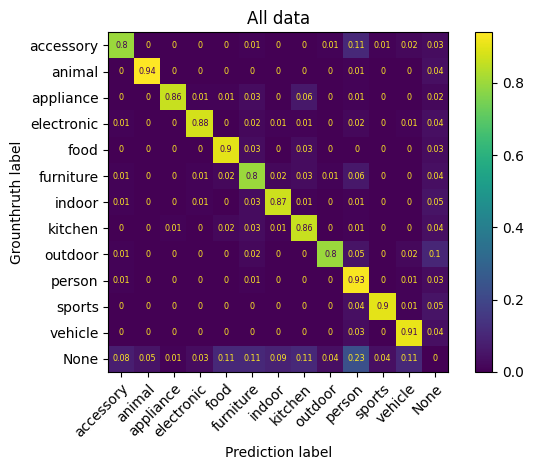

In [8]:
display_confusion_matrix(
    confusion_data.loc[confusion_data["model"] == "predictions"].drop(columns="model"),
    title="All data",
)

### Display confusion matrix for a specific group of prediction dataframe named "predictions"

Here, we divide the evaluation dataset in 3 groups of equal size based on box_height

Processing confusion matrix for model=predictions


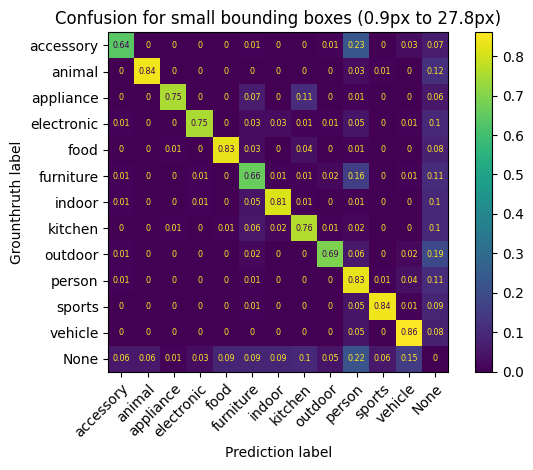

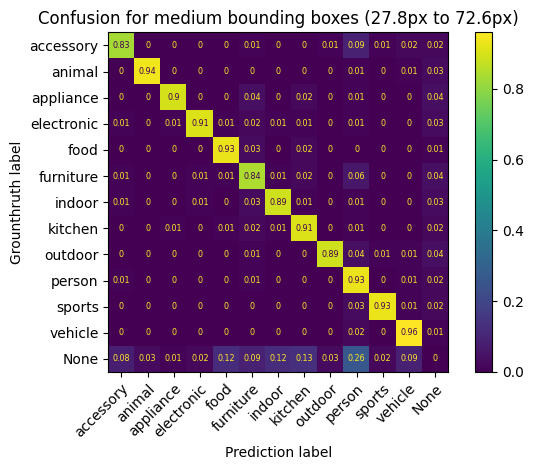

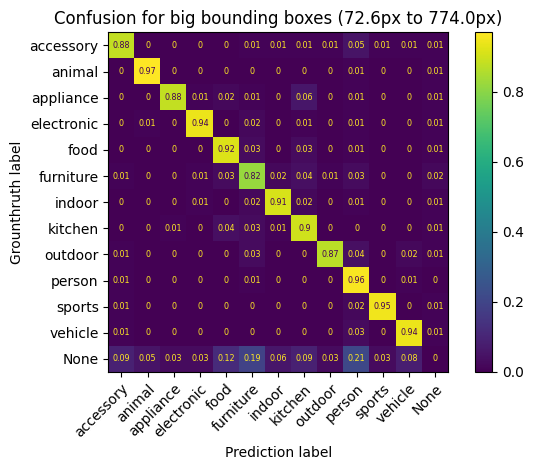

In [9]:
box_height_group = ContinuousGroup(name="box_height", bins=3, qcut=True)
confusion_data = evaluator.compute_confusion_matrix(
    "predictions", groups=[box_height_group]
)
for (range_data, data), name in zip(
    confusion_data.groupby("box_height"), ["small", "medium", "big"]
):
    display_confusion_matrix(
        data.drop("model", axis=1),
        title=(
            f"Confusion for {name} bounding boxes ({range_data.left:.1f}px to"
            f" {range_data.right:.1f}px)"
        ),
    )

## Computing AP + Yolov5 metrics

Here, we follow usual convention, by computing Average precision per class and per iou threshold.

The we get the AP per category, the AP\@0.5:0.95 per class and finally the mAP and the mAP\@0.5:0.95

see original code for yolov5 (if you dare) here : https://github.com/ultralytics/yolov5/blob/master/val.py

Namely, In addition to AP and mAP, we want the precision\@0.5 at best F1 score averaged over categories, and the recall\@0.5 at best F1 score averaged over categories

Notice, how we use the "index column" and "index_values" argument, to enforce that every category has the same confidence_threshold coordinates, i.e. 100 evenly spaced points between 0 and 1

* `ious` are the different minimum iou values to consider a detection valid
* `index_column` is the name of the value we want to use as index. This will force all values in the PR curve to be aligned. If not set, the resulting PR dataframe will no longer have aligned values, only where it actually changes, which depends on the category. This value can be `recall`, `precision` or `confidence_threshold`.
* `index_values` are the values we want the curves to be aligned on. Typically, a set of increasing values between 0 and 1

In [10]:
pr, ap = evaluator.compute_precision_recall(
    predictions_names="predictions",
    ious=np.linspace(0.5, 0.95, 10).round(3),
    index_column=None,
)

print(f"mAP@0.5 = {ap[ap['iou_threshold'] == 0.5]['AP'].mean()}")
print(f"mAP@0.5:0.95 = {ap['AP'].mean()}")

pr50, ap50 = evaluator.compute_precision_recall(
    predictions_names="predictions",
    ious=0.5,
    index_column="confidence_threshold",
    index_values=np.linspace(0, 1, 101),
    f_scores_betas=(0.5, 1, 2),
)


# Note that next line would be invalid if we did not force the data points
# to be aligned on the same confidence thresholds
mean_f1 = pr50.groupby("confidence_threshold").mean(numeric_only=True)
best_mean_f1_score = mean_f1.loc[mean_f1["f1_score"].idxmax()]
print("F1 scores averaged over classes")
print(f"best F1 = {best_mean_f1_score['f1_score']}")
print(f"precision @ best F1 = {best_mean_f1_score['precision']}")
print(f"recall @ best F1 = {best_mean_f1_score['recall']}")

Processing PR curves for 10 IoU values and 1 prediction set


  0%|          | 0/10 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.5


  0%|          | 0/12 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.55


  0%|          | 0/12 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.6


  0%|          | 0/12 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.65


  0%|          | 0/12 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.7


  0%|          | 0/12 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.75


  0%|          | 0/12 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.8


  0%|          | 0/12 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.85


  0%|          | 0/12 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.9


  0%|          | 0/12 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.95


  0%|          | 0/12 [00:00<?, ?it/s]

mAP@0.5 = 0.6498968780927252
mAP@0.5:0.95 = 0.42891943233976043
Processing PR curves for 1 IoU value and 1 prediction set


  0%|          | 0/1 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.5


  0%|          | 0/12 [00:00<?, ?it/s]

F1 scores averaged over classes
best F1 = 0.6796615734692385
precision @ best F1 = 0.7775421755626403
recall @ best F1 = 0.6053440216989199


Detailed view of Average Precision

In [11]:
display(ap)
ap_consolidated = pd.pivot_table(
    ap, values=["AP"], index="category_id", columns="iou_threshold"
)
ap_consolidated["mean"] = ap_consolidated["AP"].mean(axis=1)
ap_consolidated

,category_id,iou_threshold,model,AP,category_str
0,3,0.50,predictions,0.597134,outdoor
1,6,0.50,predictions,0.721360,sports
2,10,0.50,predictions,0.764937,electronic
3,1,0.50,predictions,0.753037,person
4,2,0.50,predictions,0.705385,vehicle
...,...,...,...,...,...
115,7,0.95,predictions,0.007749,kitchen
116,8,0.95,predictions,0.008157,food
117,5,0.95,predictions,0.004675,accessory
118,9,0.95,predictions,0.010017,furniture


AP                                                    \
iou_threshold       0.5      0.55       0.6      0.65       0.7      0.75   
category_id                                                                 
1              0.753037  0.733141  0.706142  0.675050  0.633008  0.572555   
2              0.705385  0.684499  0.654428  0.617852  0.568129  0.509032   
3              0.597134  0.573298  0.542712  0.505465  0.460946  0.402181   
4              0.809120  0.792082  0.771095  0.752684  0.710266  0.661858   
5              0.545883  0.522724  0.496112  0.451250  0.401432  0.351153   
6              0.721360  0.698412  0.675466  0.631736  0.585244  0.511800   
7              0.633795  0.608658  0.589705  0.553673  0.513385  0.459115   
8              0.534568  0.515136  0.497975  0.475205  0.443999  0.404173   
9              0.559138  0.535121  0.509976  0.478727  0.438717  0.381115   
10             0.764937  0.741044  0.722345  0.699577  0.662266  0.607944   
11             0.708608  0.685999  0.669677  0.637319  0.611345  0.545455   
12             0.465797  0.441133  0.409100  0.377720  0.347016  0.307648   

                                                           mean  
iou_threshold       0.8      0.85       0.9      0.95            
category_id                                                      
1              0.480146  0.347291  0.166231  0.016167  0.508277  
2              0.430359  0.300238  0.145796  0.016360  0.463208  
3              0.321357  0.227830  0.112498  0.014179  0.375760  
4              0.587514  0.472446  0.279467  0.028271  0.586480  
5              0.273807  0.163924  0.058987  0.004675  0.326995  
6              0.397510  0.275971  0.114413  0.008772  0.462068  
7              0.378472  0.265622  0.115670  0.007749  0.412584  
8              0.339061  0.243377  0.119867  0.008157  0.358152  
9              0.315271  0.215113  0.094218  0.010017  0.353741  
10             0.524356  0.387244  0.176262  0.012471  0.529845  
11             0.458379  0.354014  0.180022  0.020759  0.487158  
12             0.242834  0.159999  0.070817  0.005585  0.282765

In [12]:
mAP = ap_consolidated.mean(axis=0)
mAP

      iou_threshold
AP    0.5              0.649897
      0.55             0.627604
      0.6              0.603728
      0.65             0.571355
      0.7              0.531313
      0.75             0.476169
      0.8              0.395755
      0.85             0.284422
      0.9              0.136187
      0.95             0.012763
mean                   0.428919
dtype: float64

mAP\@0.5:0.95 is thus equal to $0.510150$


### Showing Curves

Now we can show the PR curve to have a look at the precision vs recall for a particular class and different IOU values. Here is an example with class 2 (persons)

First, we plot the different PR curves for different IOU threshold values,

and then we plot the f1 score vs confidence_threshold.

Finally, for an IoU threshold of 0.5, we plot recall, precision and F1_score vs confidence threshold

#### Recall vs Precision vs IoU threshold

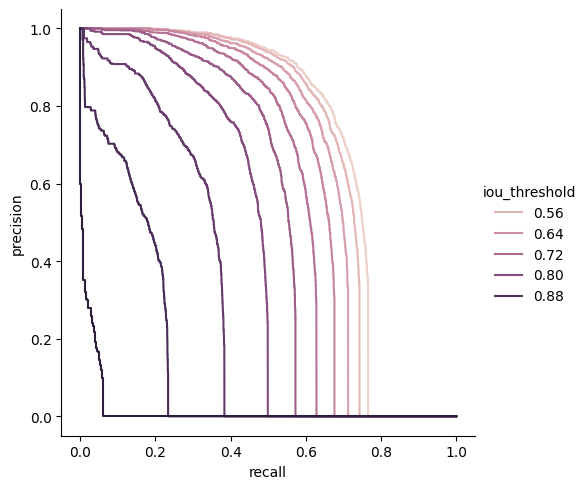

In [13]:
pr_persons = pr[pr["category_id"] == 2]
sns.relplot(
    data=pr_persons,
    x="recall",
    y="precision",
    hue="iou_threshold",
    kind="line",
    estimator=None,
    sort=False,
)
plt.show()

#### F1 score vs confidence_threshold vs IoU threshold

Notice how the optimal confidence threshold is lower with the IoU

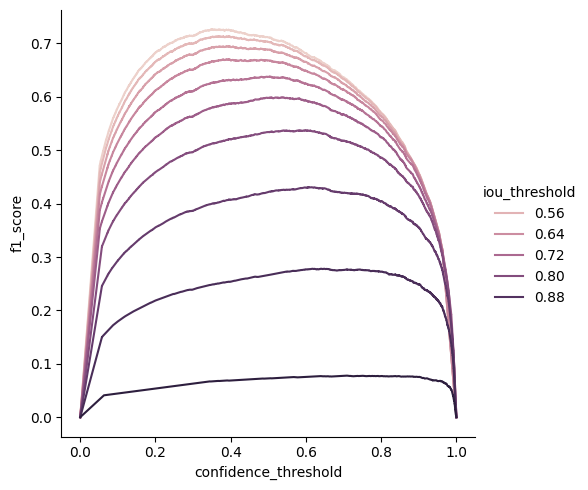

In [14]:
sns.relplot(
    data=pr_persons,
    x="confidence_threshold",
    y="f1_score",
    hue="iou_threshold",
    kind="line",
    estimator=None,
    sort=False,
)
plt.show()

#### Precision, recall, $F_\beta$ score \@0.5 vs confidence threshold for persons
Here, we graph recall, precision and F0.5, F1, and F2 with respect to confidence_threshold, for an IoU threshold of 0.5

In addition, we annotate the confidence values where the F05, F1 and F2 scores are the highest, to show how each score weights precision and recall.

Note that we don't use seaborn for this plot

Side note, We can very clearly see that this set of predictions was cut off at a confidence threshold of 0.05

We could lower that threshold, but it would dramatically increase the number of predictions without adding much information to the plot.

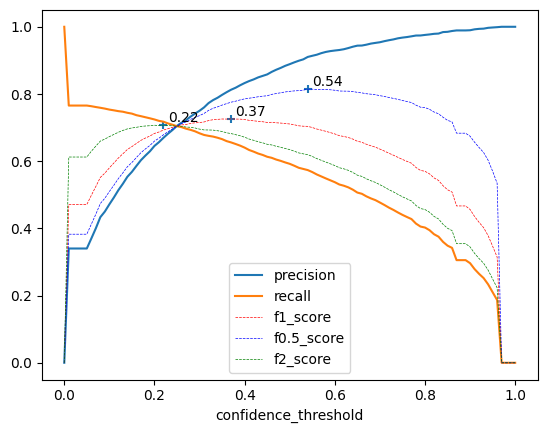

In [15]:
to_plot = pr50[pr50["category_id"] == 2].set_index("confidence_threshold")

f_scores = to_plot[["f1_score", "f0.5_score", "f2_score"]]
best_confidences = f_scores.idxmax()

fig, ax = plt.subplots()
to_plot[["precision", "recall"]].plot(ax=ax)
to_plot[["f1_score", "f0.5_score", "f2_score"]].plot(
    style=["r--", "b--", "g--"], ax=ax, linewidth=0.5
)
plt.scatter(f_scores.idxmax(), f_scores.max(), marker="+")
for x, y in zip(f_scores.idxmax(), f_scores.max()):
    ax.annotate(
        f"{x:.2f}",
        [x + 0.01, y + 0.01],
    )
plt.show()

## Computing grouped pr and ap curves

Now is time to make things more interesting

* `box_group` is how we want to split the data. Most usual group is `category_id`, but here we add the `box_height` group with 10 bins.
  Be careful, the more groups you add, the more granular your curves become but the less data you have for each.
* `image_group` is not used here but could be used the same as `box_groups` with e.g. weather condition or focal length

Notice we don't use index alignment anymore

In [16]:
from libia.utils.grouper import ContinuousGroup

box_height_group = ContinuousGroup(name="box_height", bins=10, qcut=True)
pr, ap = evaluator.compute_precision_recall(
    predictions_names="predictions",
    ious=(0.3, 0.5, 0.7, 0.9),
    groups=["category_id", box_height_group],
    index_column=None,
)

Processing PR curves for 4 IoU values and 1 prediction set


  0%|          | 0/4 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.3


  0%|          | 0/120 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.5


  0%|          | 0/120 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.7


  0%|          | 0/120 [00:00<?, ?it/s]

Processing PR curve for model=predictions and IOU=0.9


  0%|          | 0/120 [00:00<?, ?it/s]

### Exploring the `pr` and `ap` DataFrames

Each given group in the former function call will have its dedicated column

In [17]:
ap[(ap["iou_threshold"] == 0.5) & (ap["category_id"] == 1)].sort_values(
    by="AP"
).reset_index()

,index,category_id,box_height,iou_threshold,model,AP,category_str
0,224,1,"(0.859, 12.196]",0.5,predictions,0.185249,person
1,216,1,"(12.196, 18.645]",0.5,predictions,0.391076,person
2,208,1,"(18.645, 25.596]",0.5,predictions,0.509320,person
3,203,1,"(25.596, 33.533]",0.5,predictions,0.565361,person
4,183,1,"(33.533, 43.947]",0.5,predictions,0.661096,person
5,170,1,"(43.947, 59.039]",0.5,predictions,0.733885,person
6,134,1,"(59.039, 83.073]",0.5,predictions,0.776807,person
7,124,1,"(83.073, 124.26]",0.5,predictions,0.826248,person
8,133,1,"(124.26, 209.234]",0.5,predictions,0.855516,person
9,128,1,"(209.234, 773.969]",0.5,predictions,0.911366,person


In [18]:
pr[
    (pr["category_id"] == 2)
    & (pr["iou_threshold"] == 0.5)
    & (pr["box_height"].apply(lambda x: x.left) == 12.196)
]

,category_id,box_height,precision,recall,confidence_threshold,f1_score,iou_threshold,model,category_str
25369,2,"(12.196, 18.645]",1.000000,0.000000,1.000000,0.000000,0.5,predictions,vehicle
25370,2,"(12.196, 18.645]",1.000000,0.154489,0.830277,0.267629,0.5,predictions,vehicle
25371,2,"(12.196, 18.645]",0.988764,0.154489,0.830062,0.267222,0.5,predictions,vehicle
25372,2,"(12.196, 18.645]",0.988764,0.183716,0.798789,0.309857,0.5,predictions,vehicle
25373,2,"(12.196, 18.645]",0.979592,0.183716,0.797168,0.309403,0.5,predictions,vehicle
...,...,...,...,...,...,...,...,...,...
25604,2,"(12.196, 18.645]",0.250206,0.634656,0.052245,0.358910,0.5,predictions,vehicle
25605,2,"(12.196, 18.645]",0.248980,0.634656,0.052017,0.357646,0.5,predictions,vehicle
25606,2,"(12.196, 18.645]",0.248980,0.636743,0.051700,0.357977,0.5,predictions,vehicle
25607,2,"(12.196, 18.645]",0.000000,0.636743,0.000000,0.000000,0.5,predictions,vehicle


### Plotting Precision - Recall curves

Here we used a filtered dataframe with only the 41 category and the easiest iou_threshold (0.5)
notice the parameters `estimator=None` and `sort=False` to be able to plot vertical lines

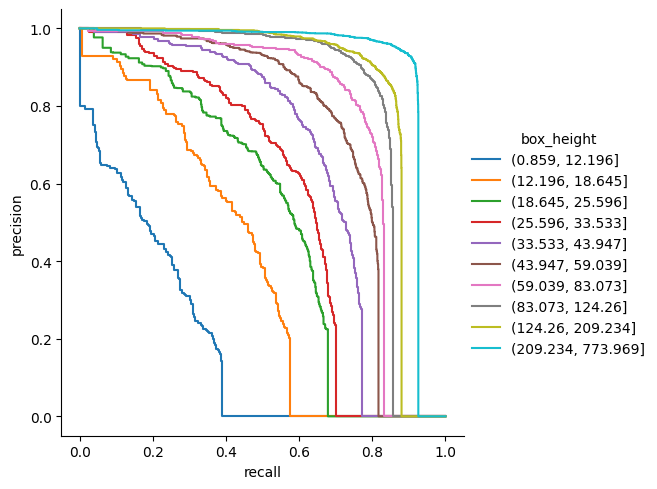

In [19]:
sns.relplot(
    data=pr[(pr["category_id"] == 1) & (pr["iou_threshold"] == 0.5)],
    x="recall",
    y="precision",
    hue="box_height",
    kind="line",
    estimator=None,
    sort=False,
)
plt.show()

Here is a more complicated example for Persons (class id = 1, the most represented class, by far)

colors and line styles can help you understand strengths and weakness of the network

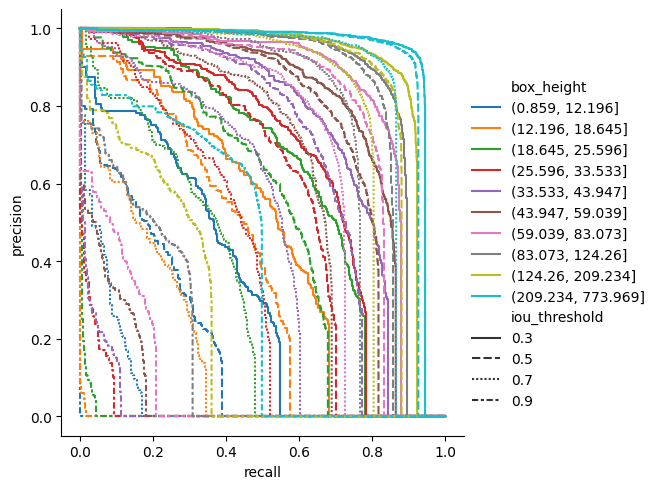

In [20]:
sns.relplot(
    data=pr[(pr["category_id"] == 1)],
    x="recall",
    y="precision",
    hue="box_height",
    style="iou_threshold",
    kind="line",
    estimator=None,
    sort=False,
)
plt.show()

## Getting Average Precision wrt to other parameters

Usually, mean AP is just a single number giving you a general idea of the network quality.

Here, we try to have a better understanding of the influence of some parameters.

Namely here, we want to know if the network is better with small or large targets.

Seaborn can let us visualise several dimensions at the same time like in the following graph

,category_id,box_height,iou_threshold,model,AP,category_str,box_mean_height
0,3,"(124.26, 209.234]",0.3,predictions,0.799908,outdoor,166.7470
1,6,"(124.26, 209.234]",0.3,predictions,0.874707,sports,166.7470
2,10,"(83.073, 124.26]",0.3,predictions,0.897088,electronic,103.6665
3,10,"(124.26, 209.234]",0.3,predictions,0.915319,electronic,166.7470
4,1,"(83.073, 124.26]",0.3,predictions,0.863140,person,103.6665
...,...,...,...,...,...,...,...
475,3,"(0.859, 12.196]",0.9,predictions,0.000000,outdoor,6.5275
476,7,"(0.859, 12.196]",0.9,predictions,0.004310,kitchen,6.5275
477,9,"(0.859, 12.196]",0.9,predictions,0.004237,furniture,6.5275
478,11,"(12.196, 18.645]",0.9,predictions,0.017868,appliance,15.4205


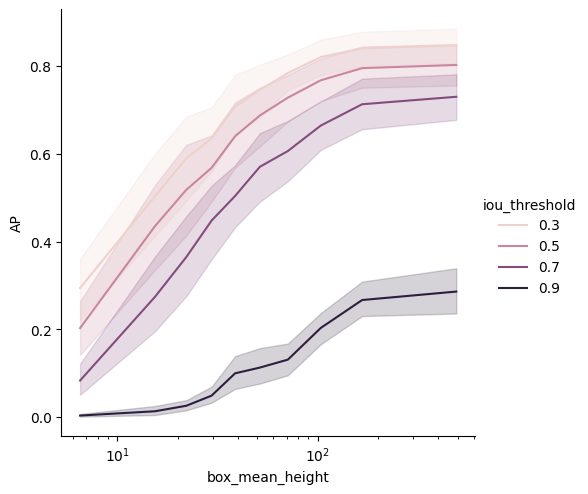

In [21]:
data = ap.copy()
data["box_mean_height"] = data["box_height"].apply(lambda x: x.mid)
data["category_str"] = data["category_id"].replace(evaluator.label_map)
display(data)
g = sns.relplot(
    data=data, x="box_mean_height", y="AP", kind="line", hue="iou_threshold"
)
g.set(xscale="log")
plt.show()

Former plot would present mean AP across all categories.

The next (very large !) grid will let you see AP vs box height for each class.

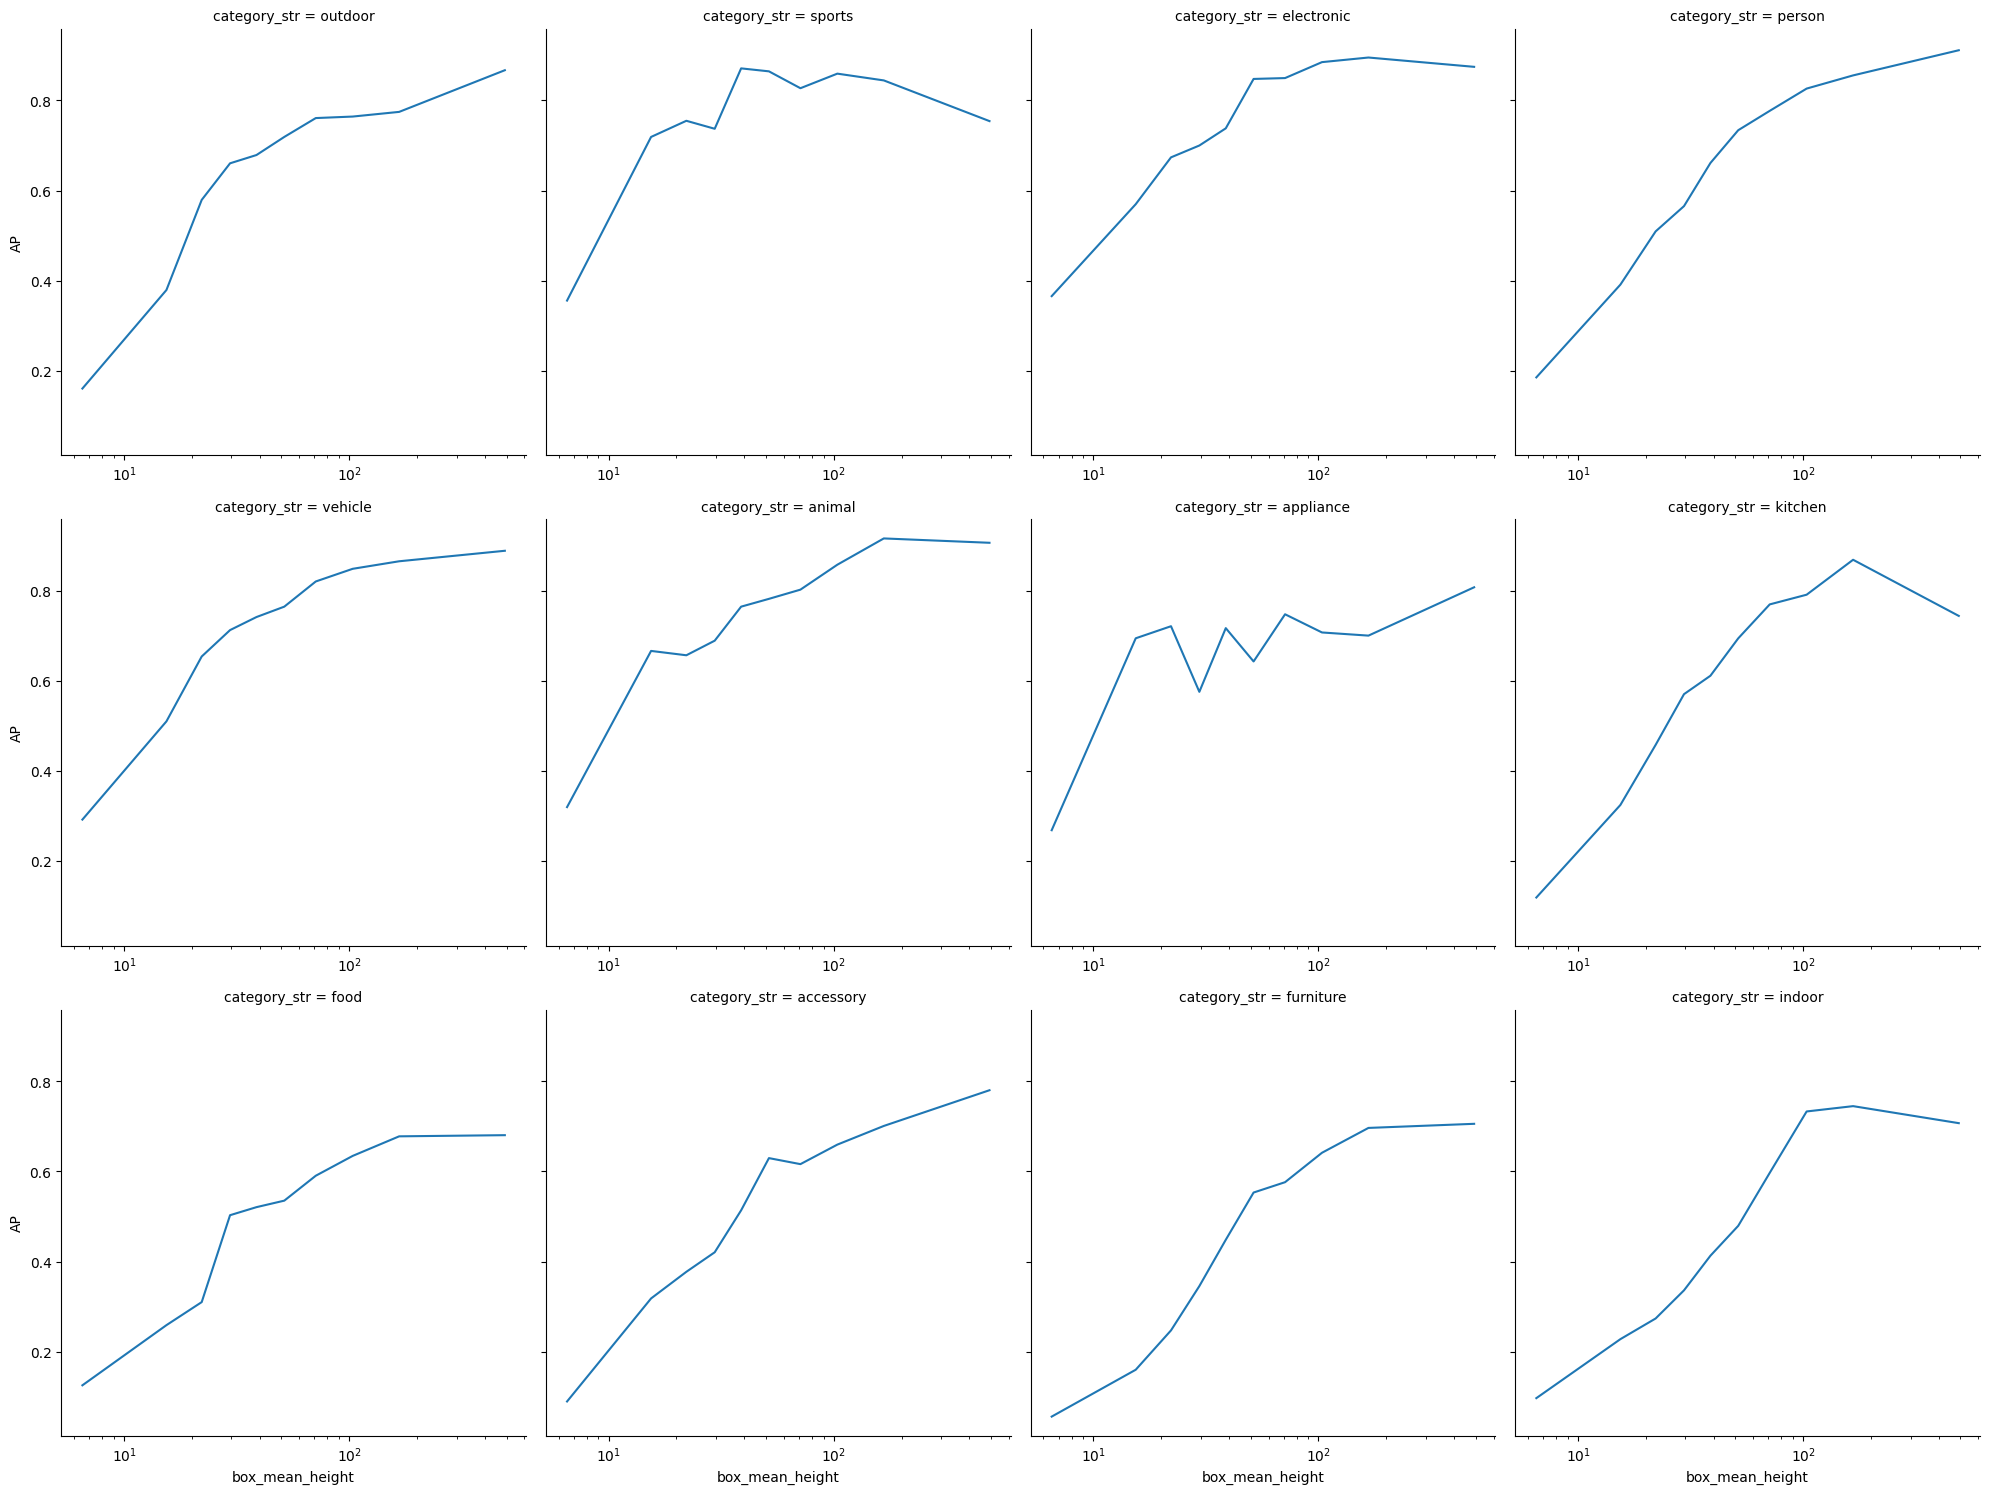

In [22]:
g = sns.relplot(
    data=data[data["iou_threshold"] == 0.5],
    x="box_mean_height",
    y="AP",
    col="category_str",
    col_wrap=4,
    kind="line",
)
g.set(xscale="log")
for axis in g.axes.flat:
    axis.tick_params(labelbottom=True)
plt.subplots_adjust(hspace=0.15)
plt.show()

## Dealing with more absolute metrics : target precision

The next usecase aims at being closer to real life metrics than AP.

In real world, AP is not that interesting because you ultimately have to choose a confidence threshold and thus a single point in the Precision/Recall curve. You will then have to make compromises between precision and recall.

Here we are interested in a target precision. Given a wanted precision (because I want to minimize the fals positive) what Recall can I hope for ? Of course this problem can easily be transposed with a target recall and the corresponding precisions

Next graphs shows an example where we want a precision of 60%. The recall values are where the different curves cross the horizontal line of value 0.6

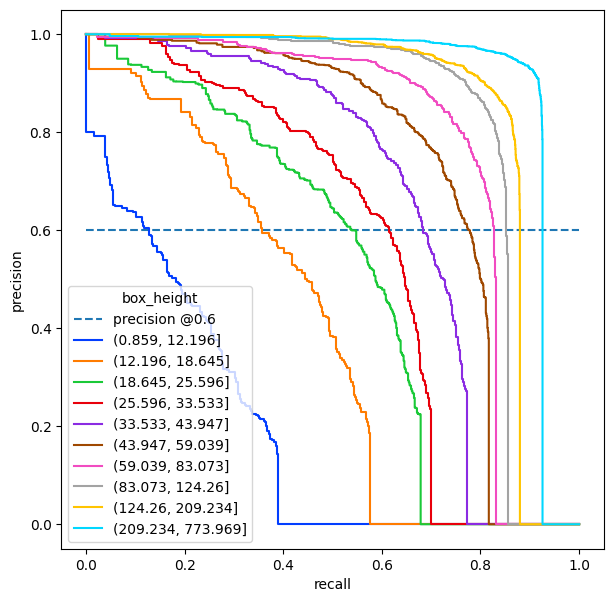

In [23]:
persons = pr[(pr["category_id"] == 1) & (pr["iou_threshold"] == 0.5)]
plt.figure(figsize=(7, 7))
precision = plt.plot([0, 1], [0.6, 0.6], label="precision @0.6", linestyle="--")
pl = sns.lineplot(
    data=persons,
    x="recall",
    y="precision",
    hue="box_height",
    estimator=None,
    sort=False,
    palette="bright",
)
plt.show()

For this example, we want the recall values for 10 different wanted precisions

In [24]:
from functools import partial


def interpolate_precision(data, value):
    if isinstance(value, float):
        value = [value]
    recall_values = np.interp(
        value, xp=data["precision"][::-1], fp=data["recall"][::-1]
    )
    recall_values = pd.Series(
        recall_values, index=pd.Index(value, name="target_precision"), name="recall"
    ).to_frame()
    return recall_values

In [25]:
recall_at_precision_persons = persons.groupby("box_height").apply(
    partial(interpolate_precision, value=np.linspace(0.1, 0.9, 5).round(3)),
    include_groups=False,
)
recall_at_precision_persons = recall_at_precision_persons.reset_index()
recall_at_precision_persons["box_mean_height"] = recall_at_precision_persons[
    "box_height"
].apply(lambda x: x.mid)

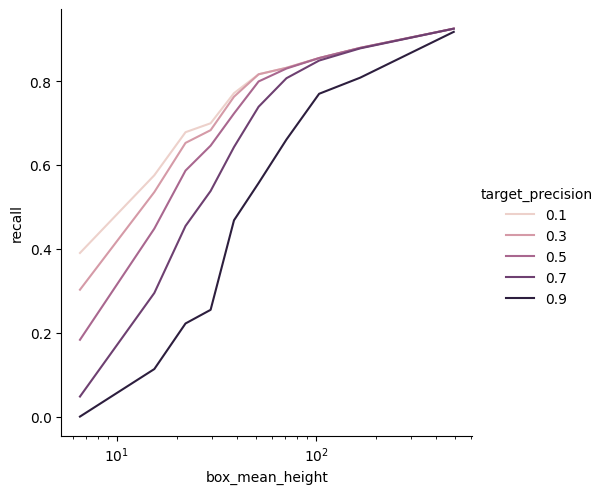

In [26]:
g = sns.relplot(
    data=recall_at_precision_persons,
    x="box_mean_height",
    hue="target_precision",
    y="recall",
    kind="line",
)
g.set(xscale="log")
plt.show()

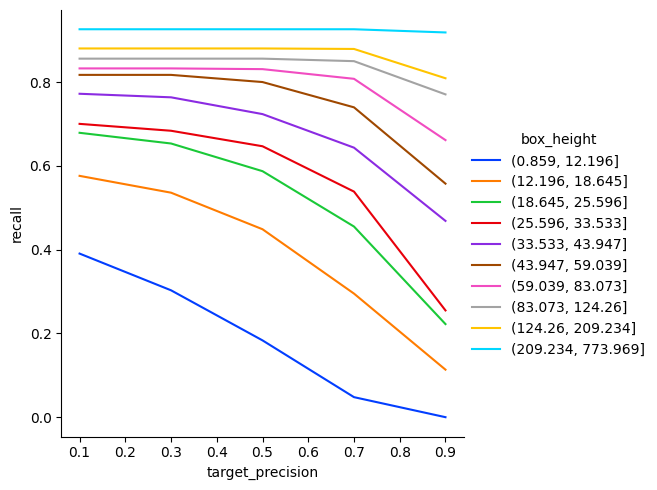

In [27]:
sns.relplot(
    data=recall_at_precision_persons,
    x="target_precision",
    hue="box_height",
    y="recall",
    kind="line",
    palette="bright",
)
plt.show()

Next example covers all classes

In [28]:
all_classes_iou_05 = pr[pr["iou_threshold"] == 0.5]
recall_at_precision = all_classes_iou_05.groupby(["box_height", "category_id"]).apply(
    partial(interpolate_precision, value=np.linspace(0.1, 0.9, 5).round(2)),
    include_groups=False,
)
recall_at_precision = recall_at_precision.reset_index()
recall_at_precision["box_mean_height"] = recall_at_precision["box_height"].apply(
    lambda x: x.mid
)
recall_at_precision["category_str"] = recall_at_precision["category_id"].replace(
    evaluator.label_map
)

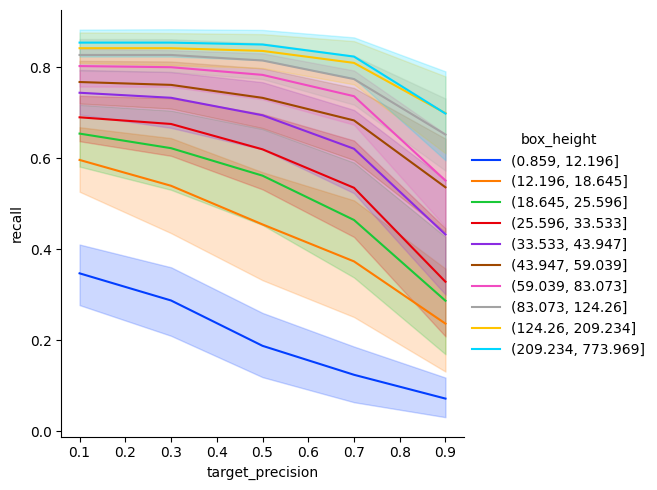

In [29]:
sns.relplot(
    data=recall_at_precision,
    x="target_precision",
    hue="box_height",
    y="recall",
    kind="line",
    palette="bright",
)
plt.show()

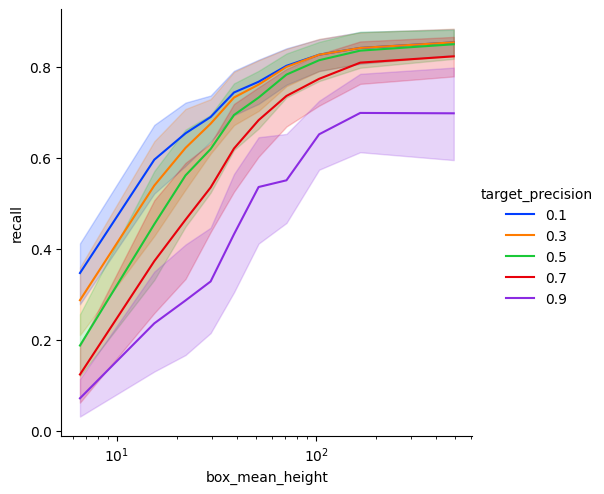

In [30]:
g = sns.relplot(
    data=recall_at_precision,
    x="box_mean_height",
    hue="target_precision",
    y="recall",
    kind="line",
    palette="bright",
)
g.set(xscale="log")
plt.show()

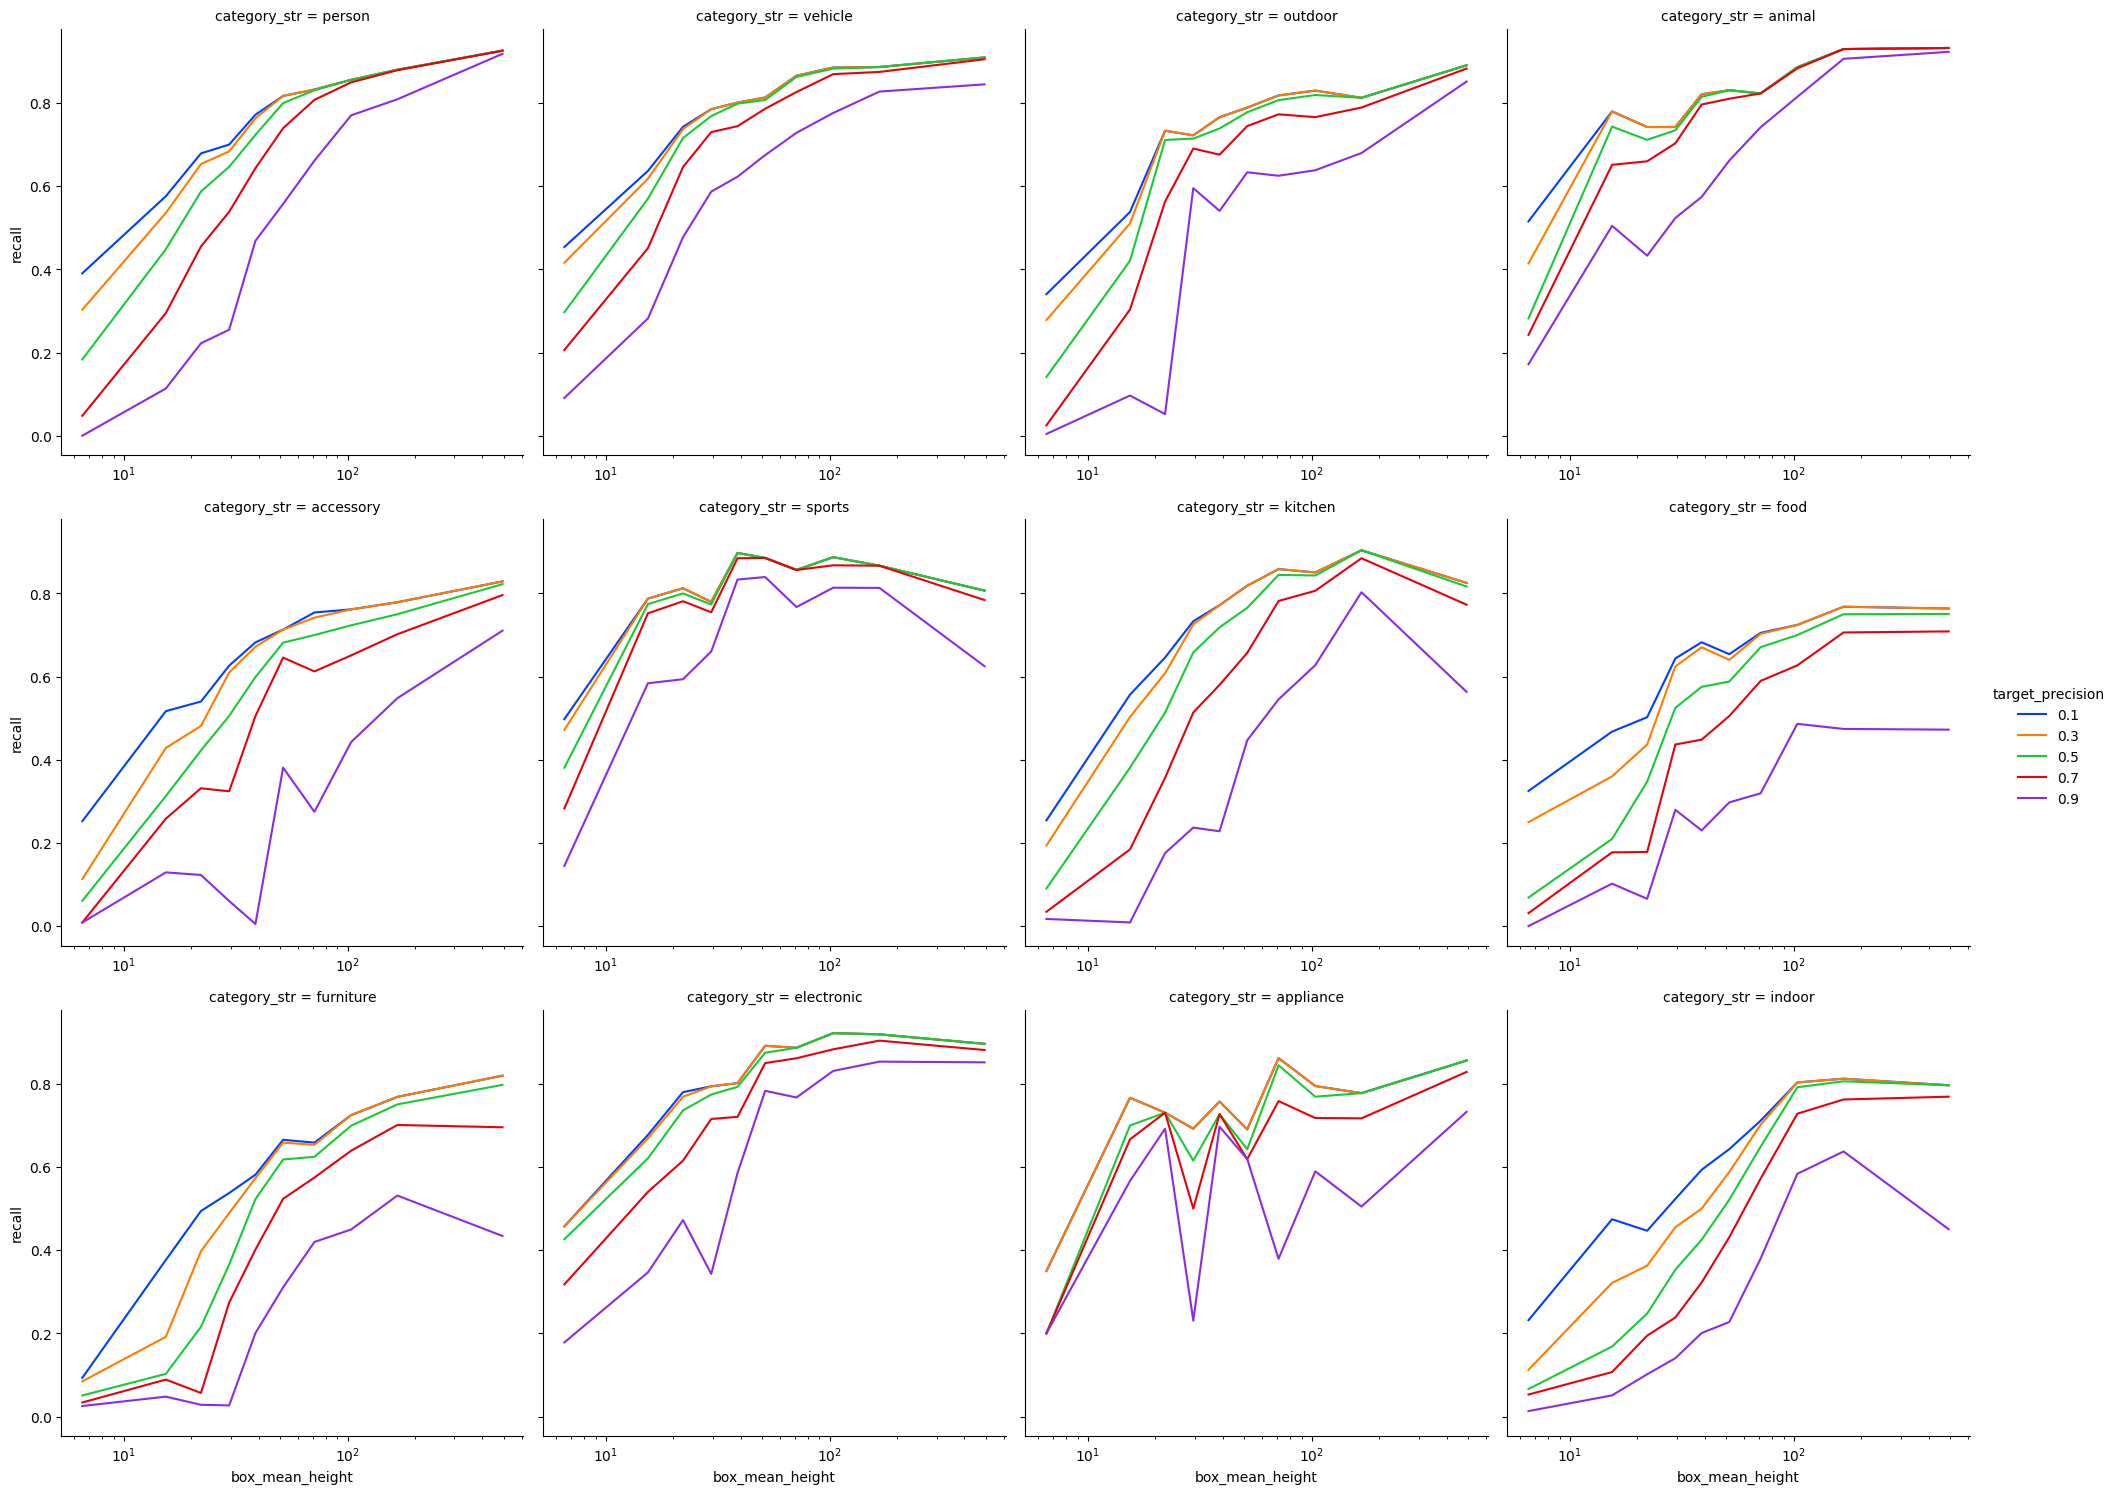

In [31]:
g = sns.relplot(
    data=recall_at_precision,
    x="box_mean_height",
    hue="target_precision",
    y="recall",
    col="category_str",
    col_wrap=4,
    kind="line",
    palette="bright",
)
g.set(xscale="log")
for axis in g.axes.flat:
    axis.tick_params(labelbottom=True)
plt.subplots_adjust(hspace=0.15)
plt.show()